In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import netCDF4
import xarray as xr
import hmp
from pathlib import Path
from mne.io import read_info
from hmpai.data import StageFinder, SAT_CLASSES_ACCURACY, SAT_CLASSES_SPEED, SAT1_STAGES_ACCURACY, SAT1_STAGES_SPEED, SAT2_STAGES_ACCURACY, SAT2_STAGES_SPEED, AR_STAGES
from hmpai.ica import ICA
import os
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from hmpai.visualization import set_seaborn_style
DATA_PATH = Path(os.getenv("DATA_PATH"))

In [8]:
# Load dataframe containing all test/val participants and which split they belong to
splits = pd.read_csv('splits.csv')
info_path = DATA_PATH / "sat2/preprocessed_500hz/preprocessed_S1_raw.fif"
# info_path = DATA_PATH / "sat1/preprocessed/processed_0001_epo.fif"
positions = read_info(info_path)
combinations = list(itertools.product(splits['SAT'].unique(), splits['condition'].unique()))
data_paths = [DATA_PATH / "sat2/data_250hz.nc"]
# Shouldnt matter which dataset this is right?
datasets = [xr.open_dataset(path) for path in data_paths]

In [3]:
fit_ac = hmp.utils.load_fit("../pipeline/250hz_accuracy_step5_50.nc")
fit_sp = hmp.utils.load_fit("../pipeline/250hz_speed_step5_50.nc")
prepars_ac = fit_ac.parameters.data[:2]
premags_ac = fit_ac.magnitudes.data[:2]
prepars_sp = fit_sp.parameters.data[:2]
premags_sp = fit_sp.magnitudes.data[:2]

SAT: accuracy, Condition: Low
Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model


  0%|          | 0/142 [00:00<?, ?it/s]

Transition event 3 found around sample 130

All events found, refitting final combination.
Estimating 3 events model
parameters estimated for 3 events model
fits/accuracy_Low.nc saved
SAT: accuracy, Condition: High
Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model


  0%|          | 0/188 [00:00<?, ?it/s]

Transition event 3 found around sample 121
Transition event 4 found around sample 152

All events found, refitting final combination.
Estimating 4 events model
parameters estimated for 4 events model
fits/accuracy_High.nc saved
SAT: accuracy, Condition: Medium
Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model


  0%|          | 0/185 [00:00<?, ?it/s]

Transition event 3 found around sample 116
Transition event 4 found around sample 171

All events found, refitting final combination.
Estimating 4 events model
parameters estimated for 4 events model
fits/accuracy_Medium.nc saved
SAT: speed, Condition: Low
Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model


  0%|          | 0/94 [00:00<?, ?it/s]

Transition event 3 found around sample 89

All events found, refitting final combination.
Estimating 3 events model
parameters estimated for 3 events model
fits/speed_Low.nc saved
SAT: speed, Condition: High
Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model


  0%|          | 0/148 [00:00<?, ?it/s]

Transition event 3 found around sample 110
Transition event 4 found around sample 139

All events found, refitting final combination.
Estimating 4 events model
parameters estimated for 4 events model
fits/speed_High.nc saved
SAT: speed, Condition: Medium
Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model


  0%|          | 0/109 [00:00<?, ?it/s]

Transition event 3 found around sample 99

All events found, refitting final combination.
Estimating 3 events model
parameters estimated for 3 events model
fits/speed_Medium.nc saved


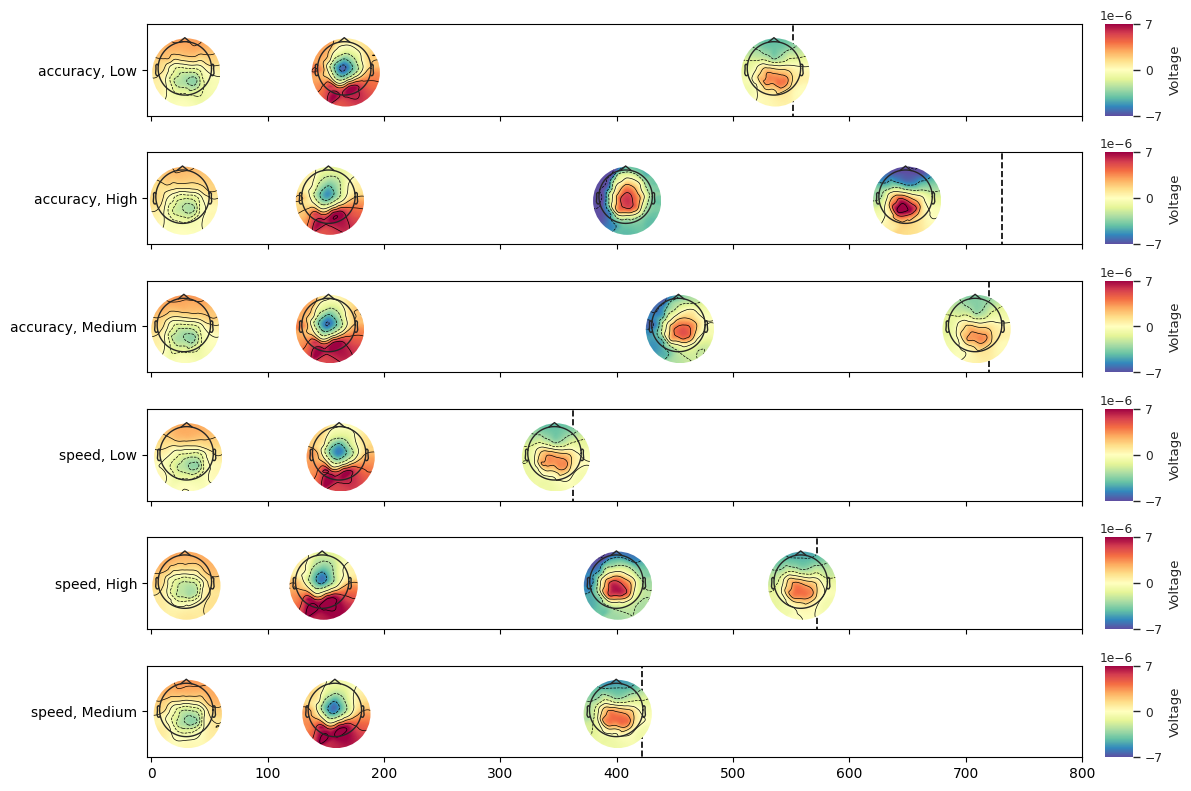

In [6]:
combinations = list(
    itertools.product(splits["SAT"].unique(), splits["condition"].unique())
)
results = []
fig, axes = plt.subplots(len(combinations), 1, sharex=True, figsize=(12, 8))
for i, (sat, cond) in enumerate(combinations):
    print(f"SAT: {sat}, Condition: {cond}")
    data_indices = splits[(splits.SAT == sat) & (splits.condition == cond)]
    selected = []
    for participant, epoch in zip(data_indices["participant"], data_indices["epochs"]):
        for dataset in datasets:
            matching_datasets = [
                ds for ds in datasets if participant in ds.participant.values
            ]
            for dataset in matching_datasets:
                selection = dataset.sel(participant=participant, epochs=epoch)
                selection = selection.expand_dims(
                dim={"participant": [participant], "epochs": [epoch]}
                )
                # if 'labels' in selection.dims and 'labels' not in selection.coords:
                #     selection = selection.assign_coords(labels=("labels", range(selection.sizes['labels'])))
                selected.append(selection)
    subset = xr.combine_by_coords(selected)
    if sat == 'accuracy':
        prepars = prepars_ac
        premags = premags_ac
    else:
        prepars = prepars_sp
        premags = premags_sp
    finder = StageFinder(
        subset,
        labels=SAT_CLASSES_ACCURACY,
        fit_function="fit",
        # fit_args={"step": 5},
        # fit_args={"by_sample": True, "prepars": prepars, "premags": premags},
        fit_args={"step": 5, "prepars": prepars, "premags": premags},
        # fit_args={"by_sample": True},
        n_comp=10,
        cpus=8,
        conditions=[],
        event_width=50,
    )
    finder.fit_model()
    hmp.utils.save_fit(finder.fits[0], f"fits/{sat}_{cond}.nc")

    ax = finder.visualize_model(positions, max_time=800, ax=axes[i])
    axes[i].set_yticklabels([f"{sat}, {cond}"])
    # results.append({'SAT': sat, 'condition': cond, 'n_events': len(labels) - 1, 'log_likelihood': likelihood})
    # Subset datasets
fig.tight_layout()
plt.show()

In [7]:
fig.savefig("../../img/final.svg", transparent=True)

In [12]:
combinations

[('accuracy', 'Low'),
 ('accuracy', 'High'),
 ('accuracy', 'Medium'),
 ('speed', 'Low'),
 ('speed', 'High'),
 ('speed', 'Medium')]

Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model
Loading fitted HMP model for No condition


/opt/conda/lib/python3.10/site-packages/xarray/core/dataarray.py:3178: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'trial_x_participant'} to avoid an error in the future.
  ds = self._to_temp_dataset().drop_vars(names, errors=errors)


Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model
Loading fitted HMP model for No condition


/opt/conda/lib/python3.10/site-packages/xarray/core/dataarray.py:3178: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'trial_x_participant'} to avoid an error in the future.
  ds = self._to_temp_dataset().drop_vars(names, errors=errors)


Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model
Loading fitted HMP model for No condition


/opt/conda/lib/python3.10/site-packages/xarray/core/dataarray.py:3178: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'trial_x_participant'} to avoid an error in the future.
  ds = self._to_temp_dataset().drop_vars(names, errors=errors)


Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model
Loading fitted HMP model for No condition


/opt/conda/lib/python3.10/site-packages/xarray/core/dataarray.py:3178: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'trial_x_participant'} to avoid an error in the future.
  ds = self._to_temp_dataset().drop_vars(names, errors=errors)


Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model
Loading fitted HMP model for No condition


/opt/conda/lib/python3.10/site-packages/xarray/core/dataarray.py:3178: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'trial_x_participant'} to avoid an error in the future.
  ds = self._to_temp_dataset().drop_vars(names, errors=errors)


Transforming epoched data to principal component (PC) space


/workspace/hmp/hmp/utils.py:530: RuntimeWarning: Mean of empty slice
  mean_last_dim = np.nanmean(data.values, axis=-1)


Fitting HMP model
Loading fitted HMP model for No condition


/opt/conda/lib/python3.10/site-packages/xarray/core/dataarray.py:3178: DeprecationWarning: Deleting a single level of a MultiIndex is deprecated. Previously, this deleted all levels of a MultiIndex. Please also drop the following variables: {'trial_x_participant'} to avoid an error in the future.
  ds = self._to_temp_dataset().drop_vars(names, errors=errors)


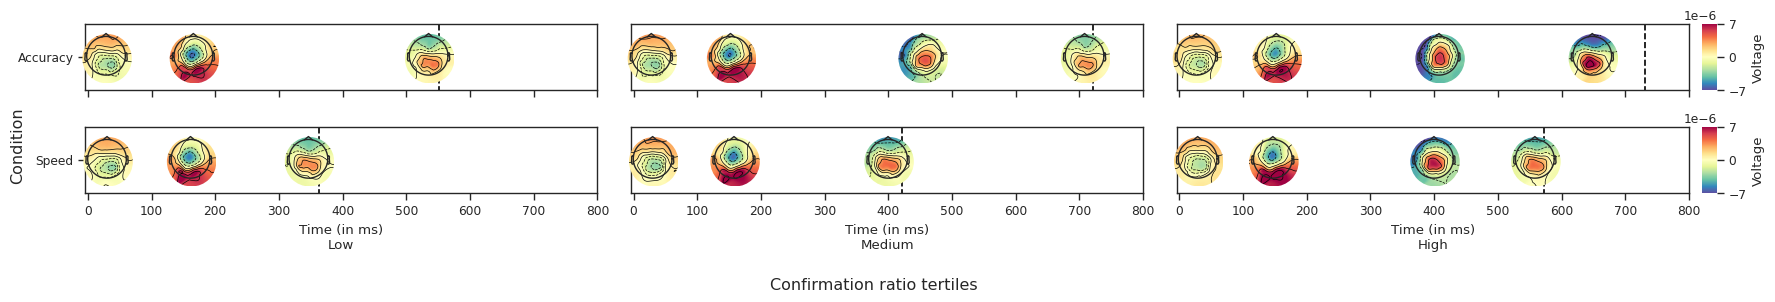

In [88]:
# Load in all fitted models
combinations = list(itertools.product(splits['SAT'].unique(), splits['condition'].unique()))
fit_path = Path("fits/")
sats = ['accuracy', 'speed']
conds = ['Low', 'Medium', 'High']
fig, ax = plt.subplots(2, 3, sharex=True, sharey=False, figsize=(18, 3))
for sat, cond in combinations:
    data_indices = splits[(splits.SAT == sat) & (splits.condition == cond)]
    selected = []
    for participant, epoch in zip(data_indices["participant"], data_indices["epochs"]):
        for dataset in datasets:
            matching_datasets = [
                ds for ds in datasets if participant in ds.participant.values
            ]
            for dataset in matching_datasets:
                selection = dataset.sel(participant=participant, epochs=epoch)
                selection = selection.expand_dims(
                dim={"participant": [participant], "epochs": [epoch]}
                )
                selected.append(selection)
    subset = xr.combine_by_coords(selected)
    finder = StageFinder(
        subset,
        labels=SAT_CLASSES_ACCURACY,
        fit_function="fit",
        # fit_args={"by_sample": True},
        n_comp=10,
        cpus=8,
        conditions=[],
        fits_to_load=[fit_path / f"{sat}_{cond}.nc"],
        event_width=50,
    )
    finder.fit_model()
    cur_ax = ax[sats.index(sat), conds.index(cond)]
    finder.visualize_model(positions, max_time=800, ax=cur_ax, colorbar=cond=='High', cond_label=sat.capitalize())
    if sat == 'speed':
        cur_ax.set_xlabel(f"Time (in ms)\n{cond}")
    if cond == 'Low':
        cur_ax.set_yticks([0.5], [sat.capitalize()])
    else:
        cur_ax.set_yticks([], [])
fig.supxlabel("Confirmation ratio tertiles")
fig.supylabel("Condition")
fig.tight_layout()
fig.savefig("../../img/refit.svg", transparent=True)

## Compare likelihoods (deprecated)

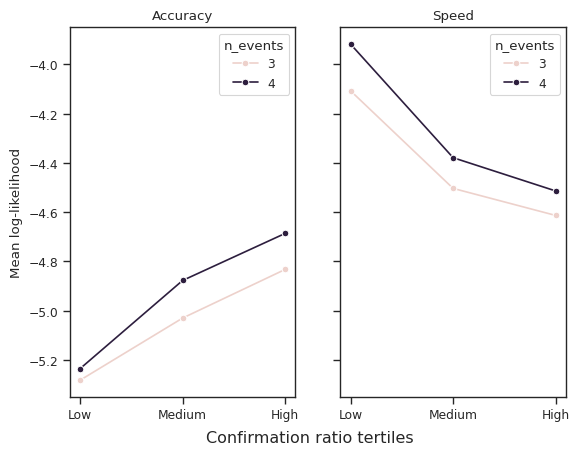

In [61]:

set_seaborn_style()
fig, ax = plt.subplots(1, 2, sharey=True)
order = ['Low', 'Medium', 'High']

fig.supxlabel('Confirmation ratio tertiles')
sns.lineplot(data[data['SAT'] == 'accuracy'], x='condition', y='log_likelihood', hue='n_events', ax=ax[0], marker="o")
sns.lineplot(data[data['SAT'] == 'speed'], x='condition', y='log_likelihood', hue='n_events', ax=ax[1], marker="o")

ax[0].set_title('Accuracy')
ax[1].set_title('Speed')
ax[0].set_ylabel('Mean log-likelihood')
ax[0].set_xlabel('')
ax[1].set_xlabel('')
plt.show()

In [ ]:
combinations = list(itertools.product(splits['SAT'].unique(), splits['condition'].unique()))
results = []
for sat, cond in combinations:
    print(f"SAT: {sat}, Condition: {cond}")
    data_indices = splits[(splits.SAT == sat) & (splits.condition == cond)]
    selected = []
    for dataset in datasets:
        for participant, epoch in zip(data_indices['participant'], data_indices['epochs']):
            if participant in dataset.participant.values:
                selection = dataset.sel(participant=participant, epochs=epoch)
                selection = selection.expand_dims(dim={'participant': [participant], 'epochs': [epoch]})
                selected.append(selection)
    subset = xr.combine_by_coords(selected)
    # 4 entries in labels == 3 event model, 5 entries == 4 event model
    for labels in [['0', '1', '2', '3'], ['0', '1', '2', '3', '4']]:
        finder = StageFinder(subset, labels=labels, fit_function='fit_single', fit_args={"starting_points": 50}, n_comp=10, cpus=8, conditions=[])
        finder.fit_model()
        likelihood = finder.fits[0].likelihoods.item()
        # Take average log-likelihood by dividing over amount of trials
        likelihood = likelihood / len(finder.fits[0].trial_x_participant)
        print(f"Events: {len(labels) - 1}, likelihood: {likelihood}")
        results.append({'SAT': sat, 'condition': cond, 'n_events': len(labels) - 1, 'log_likelihood': likelihood})
    # Subset datasets